### ISA 414 Final Project - Stock Predictions through Unsupervised Sentiment Analysis
##### Ethan Buege, Jorge Nadjar, Mac Magyaros

Libraries being used:
- Pandas
- Numpy
- PSAW (Python Pushshift.io API Wrapper)
- PRAW (Python Reddit API Wrapper)
- PyTorch
- sklearn

In [639]:
# standard python libraries
import time
import logging

# data handling
import pandas as pd
import numpy as np
import pickle


# scikit learn
import gensim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay

# pytorch
import torch
import torch.nn as nn

# visualization
import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
use_cuda = torch.cuda.is_available()

Set desired ticker (from stocks we have data for) and run all to build, train, and evaluate RNN model <br>
note: you must have the 4 files below already saved to disk, but those 4 are all you need

In [640]:
ticker = 'TSLA'

vectorized_posts = pickle.load(open(f'{ticker}_vectorized_posts.p', "rb"))
daily_upvotes = pickle.load(open(f'{ticker}_daily_upvotes.p', "rb"))
daily_volume = pickle.load(open(f'{ticker}_daily_volume.p', "rb"))
prices = pd.read_csv(f'{ticker}_prices.csv')

### Addition - Jorge

In [641]:
keys_values = vectorized_posts.items()
posts_string = {key.strftime('%Y-%m-%d'): value for key, value in keys_values}
prices['docvec'] = prices['from'].map(posts_string)

keys_values = daily_upvotes.items()
posts_string = {key.strftime('%Y-%m-%d'): value for key, value in keys_values}
prices['upvotes'] = prices['from'].map(posts_string)

keys_values = daily_volume.items()
posts_string = {key.strftime('%Y-%m-%d'): value for key, value in keys_values}
prices['post volume'] = prices['from'].map(posts_string)

prices

,from,open,high,low,close,volume,afterHours,preMarket,docvec,upvotes,post volume
0,2017-04-24,61.844,62.110,61.2043,61.606,25417525,61.5460,62.000,"[1.726876, 2.007498, -0.099510744, -0.20814693...",167.0,1.0
1,2017-04-25,61.600,62.796,61.1720,62.758,33688540,62.7500,61.700,NaN,NaN,NaN
2,2017-04-26,62.474,62.900,61.8000,62.034,23475220,62.0020,62.628,NaN,NaN,NaN
3,2017-04-27,62.338,62.618,61.5000,61.726,17342845,61.8200,61.980,"[-1.8342429, 3.2865958, -1.2044606, 1.9065353,...",43.0,2.0
4,2017-04-28,61.966,62.960,61.6000,62.814,22527390,62.9200,61.958,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1255,2022-04-18,989.030,1014.920,973.4100,1004.290,17237387,1013.0200,987.250,NaN,NaN,NaN
1256,2022-04-19,1005.060,1034.940,995.3250,1028.150,16604744,1018.0000,1008.180,NaN,NaN,NaN
1257,2022-04-20,1030.000,1034.000,975.2501,977.200,23534922,1031.1800,1015.240,NaN,NaN,NaN
1258,2022-04-21,1074.730,1092.220,996.4150,1008.780,35136565,1011.3999,1031.610,NaN,NaN,NaN


Scale close price, upvotes, and post volume to be between -1 and 1. <br>
Failing to normalize inputs has severe adverse effects on model performance and accuracy

In [642]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# this is ugly but it works
price = prices[['close']]
price['close'] = scaler.fit_transform(price['close'].values.reshape(-1, 1))
upvotes = prices[['upvotes']]
upvotes['upvotes'] = scaler.fit_transform(upvotes['upvotes'].values.reshape(-1, 1))
upvotes = upvotes.fillna(0)
volume = prices[['post volume']]
volume['post volume'] = scaler.fit_transform(volume['post volume'].values.reshape(-1, 1))
volume = volume.fillna(0)
print(price.shape)
print(upvotes.shape)
print(volume.shape)

(1260, 1)
(1260, 1)
(1260, 1)


C:\Users\admin\AppData\Local\Temp/ipykernel_19972/3257465401.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['close'] = scaler.fit_transform(price['close'].values.reshape(-1, 1))
C:\Users\admin\AppData\Local\Temp/ipykernel_19972/3257465401.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upvotes['upvotes'] = scaler.fit_transform(upvotes['upvotes'].values.reshape(-1, 1))
C:\Users\admin\AppData\Local\Temp/ipykernel_19972/3257465401.py:9: SettingWithCopyWarning: 
A value is trying to be set on a c

In [643]:
n = len(price)
price_list = price['close'].tolist()
docscaler = MinMaxScaler(feature_range=(-1, 1))

docvecs = prices['docvec'].to_numpy()
for i in range(n):
    if not isinstance(docvecs[i], (list,pd.Series,np.ndarray)):
        docvecs[i] = np.zeros(125)
    else:
        # this method of normalization likely loses some some data contained in doc embeddings since it is refit for
        # every sample but I didn't have time to figure out a more thorough solution
        docvecs[i] = docscaler.fit_transform(docvecs[i].reshape(-1, 1)).reshape(125,)

# docvecs = docvecs.reshape(1260, 300)
docvecs = docvecs.tolist()
docvecs = np.array(docvecs)
print(docvecs.shape)
print(docvecs[0])
# print(docvecs[1])



(1260, 125)
[ 8.60787809e-01  9.99999762e-01 -4.52528149e-02 -9.91454497e-02
  6.15618944e-01  1.89995855e-01 -1.01474449e-01 -3.82151127e-01
 -1.00000000e+00 -4.49706376e-01  5.05694985e-01  2.34566882e-01
  1.09123491e-01  5.56687534e-01  6.25730634e-01  1.67981386e-01
 -8.35292518e-01  2.65967786e-01  1.03776313e-01  2.41557032e-01
 -2.53775030e-01  4.82545719e-02 -3.71755153e-01 -3.86464953e-01
  7.51884818e-01  4.08232331e-01  1.56154856e-05  6.50052190e-01
  4.79399227e-03  1.29742548e-04 -4.42997605e-01 -4.78237092e-01
 -9.36860666e-02  5.82113624e-01 -6.20975733e-01  1.54321805e-01
 -2.92564213e-01  9.07510519e-02 -8.46413672e-02  4.03917164e-01
  1.21865973e-01  3.08459193e-01  1.73912849e-02  2.61080533e-01
  1.33561388e-01  3.26485902e-01 -3.04840028e-01  1.25943631e-01
  6.11380935e-01 -8.68129805e-02  2.79566914e-01 -4.46677715e-01
 -7.02414513e-01 -3.17593277e-01  1.25644788e-01  5.34202278e-01
  9.72363293e-01  1.45980626e-01  2.12652713e-01 -4.53015298e-01
 -3.29902738e

In [644]:
data = np.concatenate((price, upvotes, volume, docvecs), axis=1)
print(data.shape)
print(data[0])


(1260, 128)
[-9.56768019e-01 -9.96803675e-01 -9.91735537e-01  8.60787809e-01
  9.99999762e-01 -4.52528149e-02 -9.91454497e-02  6.15618944e-01
  1.89995855e-01 -1.01474449e-01 -3.82151127e-01 -1.00000000e+00
 -4.49706376e-01  5.05694985e-01  2.34566882e-01  1.09123491e-01
  5.56687534e-01  6.25730634e-01  1.67981386e-01 -8.35292518e-01
  2.65967786e-01  1.03776313e-01  2.41557032e-01 -2.53775030e-01
  4.82545719e-02 -3.71755153e-01 -3.86464953e-01  7.51884818e-01
  4.08232331e-01  1.56154856e-05  6.50052190e-01  4.79399227e-03
  1.29742548e-04 -4.42997605e-01 -4.78237092e-01 -9.36860666e-02
  5.82113624e-01 -6.20975733e-01  1.54321805e-01 -2.92564213e-01
  9.07510519e-02 -8.46413672e-02  4.03917164e-01  1.21865973e-01
  3.08459193e-01  1.73912849e-02  2.61080533e-01  1.33561388e-01
  3.26485902e-01 -3.04840028e-01  1.25943631e-01  6.11380935e-01
 -8.68129805e-02  2.79566914e-01 -4.46677715e-01 -7.02414513e-01
 -3.17593277e-01  1.25644788e-01  5.34202278e-01  9.72363293e-01
  1.45980626e

Slice data and construct training/test sets <br>
We use the past 19 data points to predict the 20th <br>
Changing lookback length has significant effects on model accuracy, and could likely be optimized further


In [645]:
lookback = 20  # lookback sequence length

def split_data(stock_data, lookback):
    data_raw = np.array(stock_data)  # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :1]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :1]

    return [x_train, y_train, x_test, y_test]

x_train, y_train, x_test, y_test = split_data(data, lookback)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
# we have to remove the last value from x_test since we have no data for the following day
x_test = torch.from_numpy(x_test[:-1]).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

print('y_train.shape = ',y_train_lstm.shape)
print('y_test.shape = ',y_test_lstm.shape)

# y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
# y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

y_train.shape =  torch.Size([992, 1])
y_test.shape =  torch.Size([248, 1])


Create categorical y-vectors where y=0 if stock price went down on the following day, and y=1 if it went up

In [646]:
y_train_categorical = np.array([int(y_train[i+1] > y_train[i]) for i in range(len(y_train_lstm) - 1)])
y_train_categorical = np.append(y_train_categorical, int(y_test[0] > y_train[-1]))

y_test_categorical = np.array([int(y_test[i+1] > y_test[i]) for i in range(len(y_test) - 1)])

y_train_categorical = torch.from_numpy(y_train_categorical).type(torch.Tensor).unsqueeze(-1)
y_test_categorical = torch.from_numpy(y_test_categorical).type(torch.Tensor).unsqueeze(-1)

print('x_train.shape = ',x_train.shape)
print('y_train_categorical.shape = ',y_train_categorical.shape)
print('x_test.shape = ',x_test.shape)
print('y_test_categorical.shape = ',y_test_categorical.shape)

x_train.shape =  torch.Size([992, 19, 128])
y_train_categorical.shape =  torch.Size([992, 1])
x_test.shape =  torch.Size([247, 19, 128])
y_test_categorical.shape =  torch.Size([247, 1])


Define model architecture and hyperparameters <br>
Note: with more time I would have experimented by adding more layers to the model <br>
I'd like to try something like 128->256->128->64->32->1

In [647]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        out = torch.sigmoid(out)
        return out

In [648]:
input_dim = 128
hidden_dim = 64
num_layers = 2
output_dim = 1
num_epochs = 125

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
# criterion = torch.nn.MSELoss(reduction='mean')
criterion = nn.BCELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

Train model over 100 epochs <br>
note: currently model trains on data from a single stock, but given more time it might be worth trying to train one
model for all the stocks we have data for.

In [649]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_categorical)
    print("Epoch ", t, "BCE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 BCE:  0.6924765706062317
Epoch  1 BCE:  0.6920216083526611
Epoch  2 BCE:  0.6916255354881287
Epoch  3 BCE:  0.6912103891372681
Epoch  4 BCE:  0.6907267570495605
Epoch  5 BCE:  0.6901557445526123
Epoch  6 BCE:  0.689491331577301
Epoch  7 BCE:  0.6887220740318298
Epoch  8 BCE:  0.68782639503479
Epoch  9 BCE:  0.6867730021476746
Epoch  10 BCE:  0.6855318546295166
Epoch  11 BCE:  0.6840888261795044
Epoch  12 BCE:  0.6824566125869751
Epoch  13 BCE:  0.6806633472442627
Epoch  14 BCE:  0.6787139773368835
Epoch  15 BCE:  0.6766062378883362
Epoch  16 BCE:  0.6743494272232056
Epoch  17 BCE:  0.671795129776001
Epoch  18 BCE:  0.6688631176948547
Epoch  19 BCE:  0.6656932830810547
Epoch  20 BCE:  0.6626235842704773
Epoch  21 BCE:  0.660101056098938
Epoch  22 BCE:  0.6580561995506287
Epoch  23 BCE:  0.6557093262672424
Epoch  24 BCE:  0.6525717377662659
Epoch  25 BCE:  0.6488564610481262
Epoch  26 BCE:  0.6450098156929016
Epoch  27 BCE:  0.6414260864257812
Epoch  28 BCE:  0.638277530670166
E

Evaluate training and test accuracy

In [650]:
y_train_pred = model(x_train)
y_test_pred = model(x_test)

test_loss = criterion(y_test_pred, y_test_categorical)
print("Test BCE: ", test_loss.item())

y_train_pred = torch.round(y_train_pred).detach().numpy()
y_test_pred = torch.round(y_test_pred).detach().numpy()

print("training accuracy: %.2f" % (np.mean(y_train_pred == y_train_categorical.numpy())))
print("testing accuracy: %.2f" % (np.mean(y_test_pred == y_test_categorical.numpy())))

Test BCE:  1.4234107732772827
training accuracy: 0.98
testing accuracy: 0.53


Confusion matrix for train data

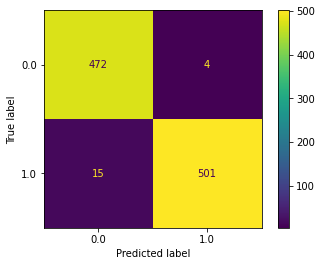

In [651]:
ConfusionMatrixDisplay.from_predictions(y_train_categorical, y_train_pred)

Confusion matrix for test data

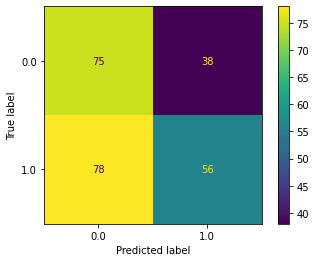

In [652]:
ConfusionMatrixDisplay.from_predictions(y_test_categorical, y_test_pred)

Optionally, save model for future use/testing

In [653]:
pickle.dump(model, open(f'{ticker}_RNN.p', "wb"))